# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Baseline**: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.
**Modifications**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).<br>
1) BiLSTM +  FC <br>
2) BiGRU + FC <br>
3) BiLSTMx2 + FC <br>
4) BiLSTM +  FC + CRF <br>
**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

**Error Analysis** (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext

from torchtext import data
from torchtext import datasets

import spacy
import numpy as np

import time
import random
import os
import matplotlib.pyplot as plt

### Read Data

In [2]:
def read_data(base_dir, datafields):
    train = []
    val = []
    test = []
    for filename in sorted(os.listdir(base_dir)):
        if str(filename) < 'wsj_0100.dp': # get train data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                train.append(torchtext.data.Example.fromlist([words, labels], datafields))
        elif str(filename) < 'wsj_0150.dp': # get val data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                val.append(torchtext.data.Example.fromlist([words, labels], datafields))
        else: # get test data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                test.append(torchtext.data.Example.fromlist([words, labels], datafields))
    return torchtext.data.Dataset(train, datafields), torchtext.data.Dataset(val, datafields), torchtext.data.Dataset(test, datafields)

### Train and evaluate utility functions

In [3]:
def categorical_accuracy(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.label
        
        optimizer.zero_grad()
        predictions = model(text)
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.label
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [4]:
text = data.Field(lower = True)
label = data.Field(unk_token = None)
fields = [('text', text), ('label', label)]
base_dir = 'dependency_treebank/'
train_data, val_data, test_data = read_data(base_dir, fields)

In [5]:
MIN_FREQ = 2

text.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

label.build_vocab(train_data)

### Create train, val and test iterator

In [6]:
BATCH_SIZE = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.text),
    sort_within_batch=False,
    repeat=False,
    shuffle=True)

## BiLSTM + FC model

In [13]:
class BiLSTM(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = 1, 
                            bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions

INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model_BiLSTM = BiLSTM(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiLSTM.embedding.weight.data.copy_(pretrained_embeddings)
model_BiLSTM.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiLSTM.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model_BiLSTM = model_BiLSTM.to(device)
criterion = criterion.to(device)

### Train

In [21]:
N_EPOCHS = 1

best_valid_loss = float('inf')
train_loss_accum1, val_loss_accum1 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _ = train(model_BiLSTM, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, _ = evaluate(model_BiLSTM, valid_iterator, criterion, TAG_PAD_IDX)
    
    train_loss_accum1.append(train_loss)
    val_loss_accum1.append(valid_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiLSTM.state_dict(), 'BiLSTM.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 54s
	Train Loss: 3.840
	 Val. Loss: 3.840


### Plot loss for train and val

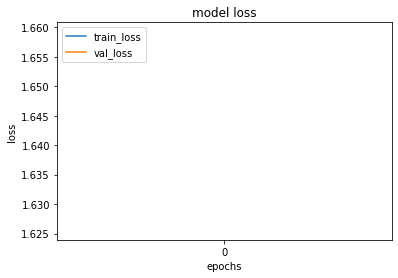

In [15]:
plt.plot(train_loss_accum1)
plt.plot(val_loss_accum1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

## BiGRU + FC model

In [24]:
class BiGRU(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout,
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, 
                          bidirectional=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.gru(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions

INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model_BiGRU = BiGRU(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiGRU.embedding.weight.data.copy_(pretrained_embeddings)
model_BiGRU.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiGRU.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model_BiGRU = model_BiGRU.to(device)
criterion = criterion.to(device)

### Train

In [25]:
N_EPOCHS = 1

best_valid_loss = float('inf')
train_loss_accum2, val_loss_accum2 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _ = train(model_BiGRU, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, _ = evaluate(model_BiGRU, valid_iterator, criterion, TAG_PAD_IDX)
    
    train_loss_accum2.append(train_loss)
    val_loss_accum2.append(valid_loss) 
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiGRU.state_dict(), 'BiGRU.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 40s
	Train Loss: 3.099
	 Val. Loss: 2.639


### Plot loss for train and val

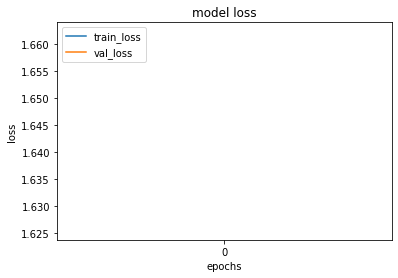

In [19]:
plt.plot(train_loss_accum2)
plt.plot(val_loss_accum2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

## BiLSTMx2 + FC model

In [20]:
class BiLSTMx2(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = True,
                            dropout = dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions
    
INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
N_LAYERS = 2 # here we will jave two LSTM layers
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
model_BiLSTMx2 = BiLSTMx2(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiLSTMx2.embedding.weight.data.copy_(pretrained_embeddings)
model_BiLSTMx2.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiLSTMx2.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model_BiLSTMx2 = model_BiLSTMx2.to(device)
criterion = criterion.to(device)

### Train

In [27]:
N_EPOCHS = 1

best_valid_loss = float('inf')
train_loss_accum3, val_loss_accum3 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _  = train(model_BiLSTMx2, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, _ = evaluate(model_BiLSTMx2, valid_iterator, criterion, TAG_PAD_IDX)
    train_loss_accum3.append(train_loss)
    val_loss_accum3.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiLSTMx2.state_dict(), 'BiLSTMx2.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 1m 38s
	Train Loss: 3.828
	 Val. Loss: 3.828


### Plot loss for train and val

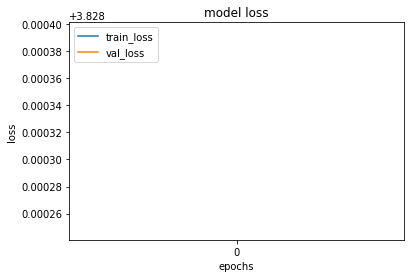

In [28]:
plt.plot(train_loss_accum3)
plt.plot(val_loss_accum3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

##  BiLSTM + FC + CRF model

In [29]:
def train_crf(model, iterator, optimizer, mean_n_tokens, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text = batch.text
        tags = batch.label
        
        loss = model(text, tags) / mean_n_tokens
        
        predictions = model.predict(text)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate_crf(model, iterator, optimizer, mean_n_tokens, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.label
            
            loss = model(text, tags) / mean_n_tokens
            predictions = model.predict(text) 
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
from torchcrf import CRF
class BiLSTM_CRF(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = 1, 
                            bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.crf = CRF(output_dim) # output_dim is len of labels
    def forward(self, text, labels):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        scores = self.fc(self.dropout(outputs))
        return -self.crf(scores, labels)
    
    def predict(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        scores = self.fc(self.dropout(outputs))
        return self.crf.decode(scores)
    
INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model_BiLSTM_CRF = BiLSTM_CRF(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiLSTM_CRF.embedding.weight.data.copy_(pretrained_embeddings)
model_BiLSTM_CRF.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiLSTM_CRF.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
model_BiLSTM_CRF = model_BiLSTM_CRF.to(device)

### Train

In [32]:
N_EPOCHS = 1

best_valid_loss = float('inf')
train_loss_accum4, val_loss_accum4, = [], []
# Count the number of words and sentences.
n_tokens_train = 0
n_sentences_train = 0
for ex in train_data:
    n_tokens_train += len(ex.text) + 2
    n_sentences_train += 1
n_tokens_valid = 0       
for ex in val_data:
    n_tokens_valid += len(ex.text)

n_batches = np.ceil(n_sentences_train / BATCH_SIZE)
mean_n_tokens = (n_tokens_train / n_batches) # * BATCH_SIZE

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train_crf(model_BiLSTM_CRF, train_iterator, optimizer, mean_n_tokens, TAG_PAD_IDX)
    valid_loss = evaluate_crf(model_BiLSTM_CRF, valid_iterator, optimizer, mean_n_tokens, TAG_PAD_IDX)
    train_loss_accum4.append(train_loss)
    val_loss_accum4.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiLSTM_CRF.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 1m 42s
	Train Loss: 5.985
	 Val. Loss: 3.810


### Plot loss for train and val

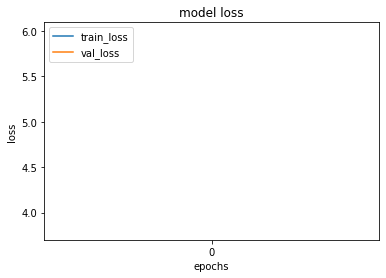

In [33]:
plt.plot(train_loss_accum4)
plt.plot(val_loss_accum4)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

### Plot all model val losses

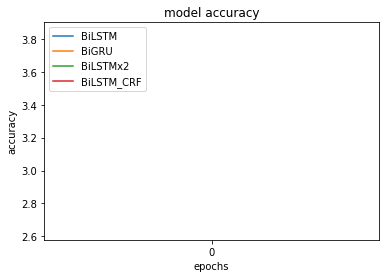

In [34]:
plt.plot(val_loss_accum1)
plt.plot(val_loss_accum2)
plt.plot(val_loss_accum3)
plt.plot(val_loss_accum4)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['BiLSTM', 'BiGRU', 'BiLSTMx2', 'BiLSTM_CRF'], loc='upper left')
plt.show()



#### Calculate f1 score for the best model and error analysis

In [35]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]

    unk_idx = text_field.vocab.stoi[text_field.unk_token]
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
         
    predictions = model(token_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    return tokens, predicted_tags, unks

In [36]:
example_index = 1

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['label']

print(sentence)

['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '.']


In [41]:
tokens, pred_tags, unks = tag_sentence(model_BiLSTMx2, 
                                       device, 
                                       sentence, 
                                       text, 
                                       label)

print(unks)

['trinity', 'railcar', 'platforms', 'trailer', 'trinity']


In [42]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

VBG		NNP		✘		trinity
IN		NNPS		✘		industries
RBS		NNP		✘		inc.
RBS		VBD		✘		said
RBS		PRP		✘		it
RBS		VBD		✘		reached
RBS		DT		✘		a
RBS		JJ		✘		preliminary
WDT		NN		✘		agreement
VBG		TO		✘		to
VBG		VB		✘		sell
:		CD		✘		500
VBG		NN		✘		railcar
VBG		NNS		✘		platforms
VBG		TO		✘		to
VBG		NNP		✘		trailer
CD		NNP		✘		train
CD		NNP		✘		co.
CD		IN		✘		of
CD		NNP		✘		chicago
CD		.		✘		.
CD		NNS		✘		terms
CD		VBD		✘		were
VBG		RB		✘		n't
VBG		VBN		✘		disclosed
VBG		.		✘		.
VBG		NNP		✘		trinity
VBG		VBD		✘		said
VBG		PRP		✘		it
VBG		VBZ		✘		plans
VBG		TO		✘		to
VBZ		VB		✘		begin
RBS		NN		✘		delivery
CD		IN		✘		in
CD		DT		✘		the
CD		JJ		✘		first
CD		NN		✘		quarter
CD		IN		✘		of
WDT		JJ		✘		next
WDT		NN		✘		year
VBZ		.		✘		.


## F1 score

In [39]:
def remove_punctuation(preds, y):
    preds_no_punct = []
    y_no_punct = []
    for i in range(len(preds)):
        if(bool(re.match('^[a-zA-Z0-9]*$', preds[i])) == True): # if not contains punct chars.
            preds_no_punct.append(preds[i])
            y_no_punct.append(y[i])
    return preds_no_punct, y_no_punct

In [44]:
from sklearn.metrics import f1_score
import re
preds = []
y = []
for i in range(len(test_data.examples)):
    actual_tags = vars(test_data.examples[i])['label']
    sentence = vars(test_data.examples[i])['text']
    _, pred_tags, _ = tag_sentence(model_BiLSTMx2, device, sentence, text, label)
    preds.append(pred_tags)
    y.append(actual_tags)
preds_unflatten = [item for sublist in preds for item in sublist]
y_unflatten = [item for sublist in y for item in sublist]
preds, y = remove_punctuation(preds_unflatten, y_unflatten)
print("F1-score: ", "{:.2f}".format(f1_score(y, preds, average='macro')))

F1-score:  0.00
